# Miscellaneous things(Pytorch ver.)
발표자 : 통합과정 최찬혁

앞서 우리는 regularization, dropout 및 batch_normalization을 tensorflow에서 적용하는 방법에 대해 알아봤습니다.

이 코드에서는 위 3가지 방법을 pytorch에서 적용하는 방법에 대해 알아보겠습니다.

## Import pakages

In [59]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import tensorflow as tf

## Download and preprocess data

In [60]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_valid = x_train[:50000], x_train[50000:]
y_train, y_valid = y_train[:50000], y_train[50000:]
x_train = x_train.reshape(50000,28*28)/255
x_valid = x_valid.reshape(-1, 28*28)/255
x_test  = x_test.reshape(-1, 28*28)/255

In [61]:
class CustomTrainDataset(Dataset):
    def __init__(self):
        self.x_data = torch.from_numpy(x_train)
        self.x_data = self.x_data.type(torch.FloatTensor)
        self.y_data = torch.from_numpy(y_train)
        self.y_data = self.y_data.type(torch.LongTensor)

    # 총 데이터의 개수를 리턴
    def __len__(self):
        return len(self.x_data)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

In [62]:
class CustomValidDataset(Dataset):
    def __init__(self):
        self.x_data = torch.from_numpy(x_valid)
        self.x_data = self.x_data.type(torch.FloatTensor)
        self.y_data = torch.from_numpy(y_valid)
        self.y_data = self.y_data.type(torch.LongTensor)

    # 총 데이터의 개수를 리턴
    def __len__(self):
        return len(self.x_data)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

In [63]:
class CustomTestDataset(Dataset):
    def __init__(self):
        self.x_data = torch.from_numpy(x_test)
        self.x_data = self.x_data.type(torch.FloatTensor)
        self.y_data = torch.from_numpy(y_test)
        self.y_data = self.y_data.type(torch.LongTensor)

    # 총 데이터의 개수를 리턴
    def __len__(self):
        return len(self.x_data)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

In [64]:
trainset = CustomTrainDataset()
validset = CustomValidDataset()
testset = CustomTestDataset()

In [65]:
trainloader = DataLoader(trainset, batch_size=250, shuffle=True)
validloader = DataLoader(validset, batch_size=250, shuffle=True)
testloader = DataLoader(testset, batch_size=250, shuffle=True)

## Useful function

학습 과정, 검증 과정 함수를 만듭니다.

train_loop : dataloader, model, loss function, optimizer를 입력받아서 1epoch 학습합니다.

test_loop : dataloader, model, loss function을 입력받아서 loss function 값 및 accuracy를 리턴합니다.

In [66]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [67]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    total_loss /= num_batches
    correct /= size
    print("loss : %.4f" %total_loss)
    print("accuracy : ", correct)
    return total_loss, correct

In [68]:
learning_rate = 0.01
MAX_EPOCHS = 100

## Regularization

regularization 방법은 loss function에 penalty를 더해서 학습하는 것입니다.

즉, 기존의 loss function을 $L_{0}$이라고 했을 때 loss function을 다음과 같이 계산하는 것으로 볼 수 있습니다.

$L = L_{0} +  \lambda _{l1} \left( \sum \left| w_{i} \right| \right)+\lambda _{l2} \left( \sum w_{i}^2\right)$

$\lambda _{l1} , \lambda _{l2}$는 하이퍼파라미터로서 적절한 값을 정해야 됩니다.

pytorch에서는 $L2$-regularization만 기본적으로 제공되며 optimizer 정의할 때 weight_decay 옵션을 이용해서 적용할 수 있습니다.


In [69]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1,self).__init__()
        self.linear = nn.Linear(784,100)
        self.sigmoid = nn.Sigmoid()
        self.final = nn.Linear(100, 10)

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        x = self.final(x)
        return x

In [70]:
model1 = Model1()
optimizer1 = torch.optim.SGD(model1.parameters(), weight_decay=0.001, lr = learning_rate)
loss_fn =  torch.nn.CrossEntropyLoss()

In [71]:
train_loss1 = []
valid_loss1 = []
train_acc1 = []
valid_acc1 = []

for epoch in range(MAX_EPOCHS):
    train_loop(trainloader, model1, loss_fn, optimizer1)
    print("Epoch #", epoch+1, " Done!!")
    print("Trainset")
    tmp1, tmp2 = test_loop(trainloader, model1, loss_fn)
    print("\nValidationset")
    tmp3, tmp4 = test_loop(validloader, model1, loss_fn)
    train_loss1.append(tmp1)
    valid_loss1.append(tmp3)
    train_acc1.append(tmp2)
    valid_acc1.append(tmp4)
    print("\n")



Epoch # 1  Done!!
Trainset
loss : 2.2520
accuracy :  0.18318

Validationset
loss : 2.2523
accuracy :  0.1764


Epoch # 2  Done!!
Trainset
loss : 2.1972
accuracy :  0.45286

Validationset
loss : 2.1959
accuracy :  0.4694


Epoch # 3  Done!!
Trainset
loss : 2.1302
accuracy :  0.46776

Validationset
loss : 2.1275
accuracy :  0.4822


Epoch # 4  Done!!
Trainset
loss : 2.0457
accuracy :  0.54444

Validationset
loss : 2.0410
accuracy :  0.5618


Epoch # 5  Done!!
Trainset
loss : 1.9427
accuracy :  0.62806

Validationset
loss : 1.9361
accuracy :  0.649


Epoch # 6  Done!!
Trainset
loss : 1.8238
accuracy :  0.64558

Validationset
loss : 1.8145
accuracy :  0.6666


Epoch # 7  Done!!
Trainset
loss : 1.6959
accuracy :  0.67076

Validationset
loss : 1.6835
accuracy :  0.6918


Epoch # 8  Done!!
Trainset
loss : 1.5669
accuracy :  0.69428

Validationset
loss : 1.5511
accuracy :  0.7147


Epoch # 9  Done!!
Trainset
loss : 1.4443
accuracy :  0.71226

Validationset
loss : 1.4248
accuracy :  0.735


Epo

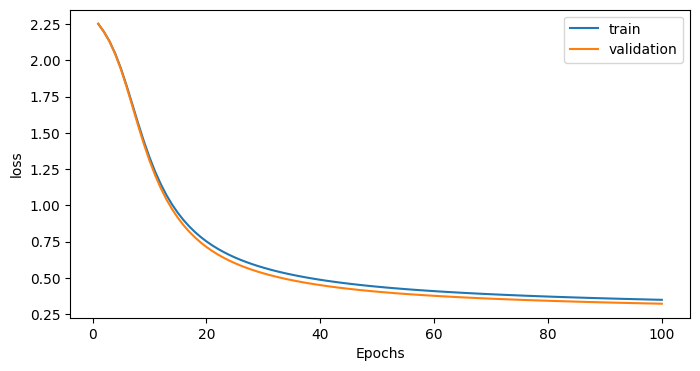

In [72]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, MAX_EPOCHS+1), train_loss1, label='train')
plt.plot(np.arange(1, MAX_EPOCHS+1), valid_loss1, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

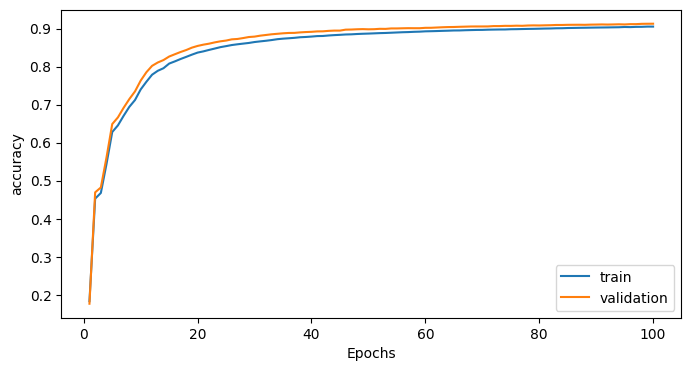

In [73]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, MAX_EPOCHS+1), train_acc1, label='train')
plt.plot(np.arange(1, MAX_EPOCHS+1), valid_acc1, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()

In [74]:
_, test_acc1 = test_loop(testloader, model1, loss_fn)
print("Accuracy for testset : ", test_acc1 * 100 , "%")

loss : 0.3312
accuracy :  0.9095
Accuracy for testset :  90.95 %


## Dropout
Drop-out은 서로 연결된 layer에서 일정 확률 $p$로 뉴런을 제거하서 학습하는 방법입니다.

여기서 일정 확률 $p$는 하이퍼파라미터로 적절한 값을 정해야 됩니다.

다만, 뉴런을 제거하는 것은 학습과정에서만 적용되며 검증과정에서는 적용하지 않습니다.

pytorch에서는 Dropout layer를 layer 사이에 추가해서 적용할 수 있습니다.

In [75]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2,self).__init__()
        self.linear = nn.Linear(784,100)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        self.final = nn.Linear(100, 10)

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        x = self.dropout(x)
        x = self.final(x)
        return x

In [76]:
model2 = Model2()
optimizer2 = torch.optim.SGD(model2.parameters(), lr = learning_rate)
loss_fn =  torch.nn.CrossEntropyLoss()

In [77]:
train_loss2 = []
valid_loss2 = []
train_acc2 = []
valid_acc2 = []

for epoch in range(MAX_EPOCHS):
    train_loop(trainloader, model2, loss_fn, optimizer2)
    print("Epoch #", epoch+1, " Done!!")
    print("Trainset")
    tmp1, tmp2 = test_loop(trainloader, model2, loss_fn)
    print("\n Validationset")
    tmp3, tmp4 = test_loop(validloader, model2, loss_fn)
    train_loss2.append(tmp1)
    valid_loss2.append(tmp3)
    train_acc2.append(tmp2)
    valid_acc2.append(tmp4)
    print("\n")

Epoch # 1  Done!!
Trainset
loss : 2.2574
accuracy :  0.20766

 Validationset
loss : 2.2573
accuracy :  0.2014


Epoch # 2  Done!!
Trainset
loss : 2.2128
accuracy :  0.3765

 Validationset
loss : 2.2118
accuracy :  0.3765


Epoch # 3  Done!!
Trainset
loss : 2.1610
accuracy :  0.4266

 Validationset
loss : 2.1590
accuracy :  0.4342


Epoch # 4  Done!!
Trainset
loss : 2.0978
accuracy :  0.54884

 Validationset
loss : 2.0945
accuracy :  0.5586


Epoch # 5  Done!!
Trainset
loss : 2.0203
accuracy :  0.58472

 Validationset
loss : 2.0154
accuracy :  0.6029


Epoch # 6  Done!!
Trainset
loss : 1.9284
accuracy :  0.61496

 Validationset
loss : 1.9214
accuracy :  0.6403


Epoch # 7  Done!!
Trainset
loss : 1.8264
accuracy :  0.65154

 Validationset
loss : 1.8172
accuracy :  0.6744


Epoch # 8  Done!!
Trainset
loss : 1.7191
accuracy :  0.68516

 Validationset
loss : 1.7078
accuracy :  0.7063


Epoch # 9  Done!!
Trainset
loss : 1.6129
accuracy :  0.70386

 Validationset
loss : 1.5988
accuracy :  0.7

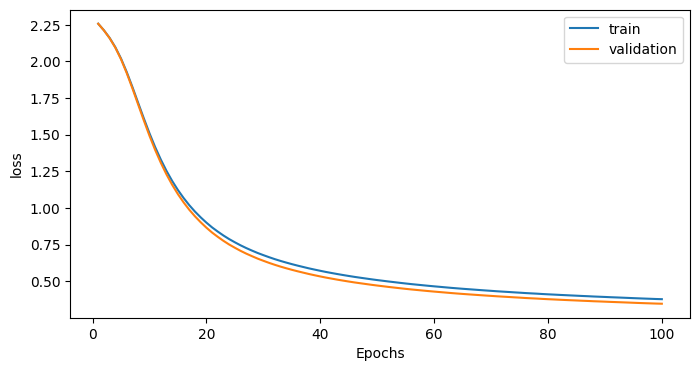

In [78]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, MAX_EPOCHS+1), train_loss2, label='train')
plt.plot(np.arange(1, MAX_EPOCHS+1), valid_loss2, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

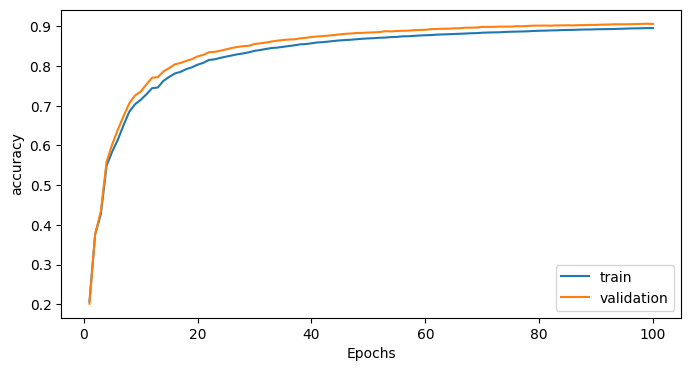

In [79]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, MAX_EPOCHS+1), train_acc2, label='train')
plt.plot(np.arange(1, MAX_EPOCHS+1), valid_acc2, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()

In [80]:
_, test_acc2 = test_loop(testloader, model2, loss_fn)
print("Accuracy for testset : ", test_acc2 * 100 , "%")

loss : 0.3598
accuracy :  0.9022
Accuracy for testset :  90.22 %


## Batch normalization

Batch normalization은 층으로 들어가는 입력값이 한쪽으로 쏠리거나 너무 퍼지거나 너무 좁아지지 않게 해주는 인공신경망 기법입니다.

여러 입력값을 모은 배치에 대해, 각 층의 입력값의 평균과 표준편차를 다시 맞추어 주어, 입력값이 쏠리는 것을 방지합니다.

pytorch에서는 Batch normalization layer를 layer 사이에 추가해서 적용할 수 있습니다.

In [81]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3,self).__init__()
        self.linear = nn.Linear(784,100)
        self.bn = nn.BatchNorm1d(100)
        self.sigmoid = nn.Sigmoid()
        self.final = nn.Linear(100, 10)

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        x = self.bn(x)
        x = self.final(x)
        return x

In [82]:
model3 = Model3()
optimizer3 = torch.optim.SGD(model3.parameters(), lr = learning_rate)
loss_fn =  torch.nn.CrossEntropyLoss()

In [83]:
train_loss3 = []
valid_loss3 = []
train_acc3 = []
valid_acc3 = []

for epoch in range(MAX_EPOCHS):
    train_loop(trainloader, model3, loss_fn, optimizer3)
    print("Epoch #", epoch+1, " Done!!")
    print("Trainset")
    tmp1, tmp2 = test_loop(trainloader, model3, loss_fn)
    print("\n Validationset")
    tmp3, tmp4 = test_loop(validloader, model3, loss_fn)
    train_loss3.append(tmp1)
    valid_loss3.append(tmp3)
    train_acc3.append(tmp2)
    valid_acc3.append(tmp4)
    print("\n")

Epoch # 1  Done!!
Trainset
loss : 0.4868
accuracy :  0.87692

 Validationset
loss : 0.4491
accuracy :  0.8914


Epoch # 2  Done!!
Trainset
loss : 0.4048
accuracy :  0.89354

 Validationset
loss : 0.3754
accuracy :  0.9044


Epoch # 3  Done!!
Trainset
loss : 0.3722
accuracy :  0.89984

 Validationset
loss : 0.3470
accuracy :  0.9115


Epoch # 4  Done!!
Trainset
loss : 0.3506
accuracy :  0.90432

 Validationset
loss : 0.3286
accuracy :  0.9125


Epoch # 5  Done!!
Trainset
loss : 0.3364
accuracy :  0.90772

 Validationset
loss : 0.3174
accuracy :  0.9156


Epoch # 6  Done!!
Trainset
loss : 0.3269
accuracy :  0.9098

 Validationset
loss : 0.3119
accuracy :  0.9164


Epoch # 7  Done!!
Trainset
loss : 0.3197
accuracy :  0.91216

 Validationset
loss : 0.3060
accuracy :  0.9171


Epoch # 8  Done!!
Trainset
loss : 0.3121
accuracy :  0.91348

 Validationset
loss : 0.2993
accuracy :  0.9173


Epoch # 9  Done!!
Trainset
loss : 0.3081
accuracy :  0.91434

 Validationset
loss : 0.2971
accuracy :  0.

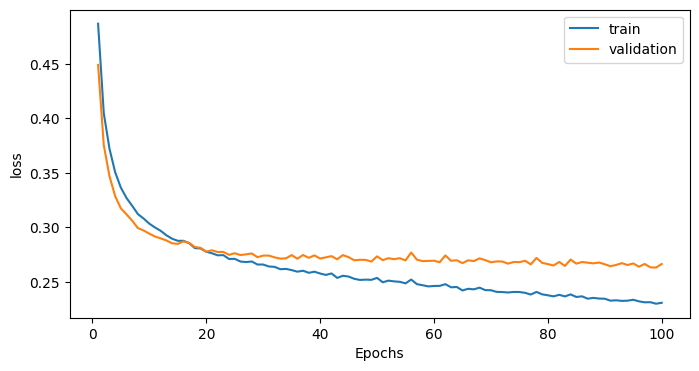

In [84]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, MAX_EPOCHS+1), train_loss3, label='train')
plt.plot(np.arange(1, MAX_EPOCHS+1), valid_loss3, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

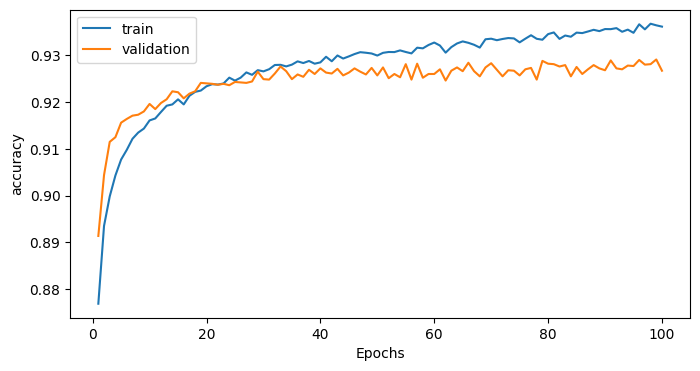

In [85]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, MAX_EPOCHS+1), train_acc3, label='train')
plt.plot(np.arange(1, MAX_EPOCHS+1), valid_acc3, label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()

In [86]:
_, test_acc3 = test_loop(testloader, model3, loss_fn)
print("Accuracy for testset : ", test_acc3 * 100 , "%")

loss : 0.2717
accuracy :  0.9244
Accuracy for testset :  92.44 %
